# Ensemble methods demo
This notebook shows how ensemble methods can improve results in a practical manner.

First, we are training two models - one decision tree and one logistic regressor. We train these on the classic [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) by Cortez et.al, which is a regression problem to predict the wine quality based on some features such as fixed acidity, citric acid, chlorides and alcohol.
Then, we combine the results and look at the mean squared error between the models predicted output and the test set, compared to each models output separately. 

In [124]:
import pandas as pd
from sklearn import tree
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

We can see that the dataset contains a lot of interesting features, and that there are a total of 4898 entries in the dataset.

In [149]:
data = pd.read_csv('winequality-white.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [74]:
# Load X and Y data and split into training and test set
Y = data['quality']
X = data.drop(['quality'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print("Shape of x train:", X_train.shape)
X.head()

Shape of x train: (3281, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [151]:
tree_model = tree.DecisionTreeClassifier()
log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)

In [152]:
# Fit both models
tree_model.fit(X_train, Y_train)
log_reg.fit(X_train, Y_train)

/home/stud2173/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [153]:
# Get both models to make predictions on the test set
y_pred_1 = tree_model.predict(X_test)
y_pred_2 = log_reg.predict(X_test)

In [154]:
def MSE(y_pred, y):
    N = len(y_pred)
    return 1/N * sum((y_pred - y)**2)

tree_loss = MSE(y_pred_1, Y_test)
log_reg_loss = MSE(y_pred_2, Y_test)
print("Loss for decision tree model: ", tree_loss)
print("Loss for logistic regression model: ", log_reg_loss)

Loss for decision tree model:  0.7260358688930117
Loss for logistic regression model:  0.6474953617810761


In [155]:
# By taking the average of both models, we get a better prediction
averaged_pred = 0.5*y_pred_1 + 0.5* y_pred_2
avg_loss = MSE(averaged_pred, Y_test)
print("Averaged prediction loss: ", avg_loss)

Averaged prediction loss:  0.509121830550402


# Searching for best ensemble weighing
Instead of taking the average of both models, we can search the weight space for the best weighing between the two models.
Here, we are searching with an increment of 0.05.

Since the weighed total is 1, we only have to plot one of the weights - w1. The other weight is 1-w1.
    We observe that the weights favor the logistic regressor (which is not surprising given that it has a bit higher accuracy).

In [156]:

WEIGHTS = np.linspace(0, 1, 21)
LOSS_VALS = []
minima = 10000
best_weights = (0, 0)
for w1 in WEIGHTS:
    w2 = 1-w1
    weighted = w1 * y_pred_1 + w2*y_pred_2
    
    loss = MSE(weighted, Y_test)
    if loss < minima:
        best_weights = w1, w2
        minima = loss
    LOSS_VALS.append(loss)

print("Found best weights to be {} with loss {}".format(best_weights, minima))

Found best weights to be (0.45, 0.55) with loss 0.5069712430426709


<IPython.core.display.Javascript object>


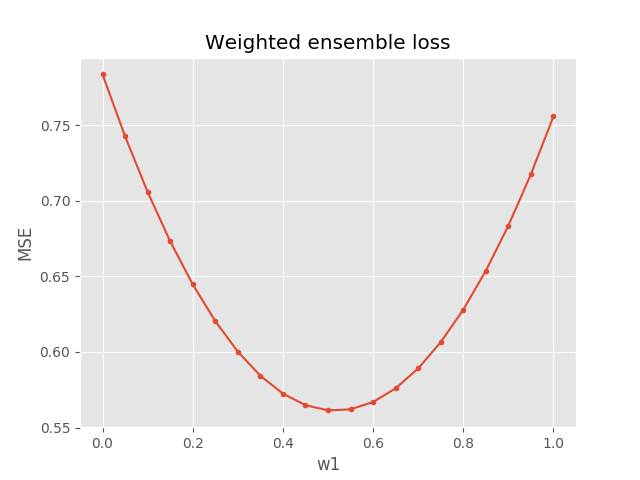

Text(0,0.5,'MSE')

In [148]:
plt.plot(WEIGHTS, LOSS_VALS, '.-')
plt.title("Weighted ensemble loss")
plt.xlabel("w1")
plt.ylabel("MSE")